In [1]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
import numpy as np
from PIL import Image
import os

In [2]:
from geo_data import create_anchor_transform
from libs.ConvNeXt.models.convnext import ConvNeXt
import matplotlib.pyplot as plt
imap = plt.imread("europe.png")

In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
trans = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

COORD_REF = np.array((50, 10))

In [4]:
device = torch.device("cuda")
model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], num_classes=2)

# model.load_state_dict(torch.load("logs/latlng_final/checkpoint-best.pth", map_location='cpu')['model'], strict=False)
# model.load_state_dict(torch.load("logs/latlng_pre/checkpoint-0.pth", map_location='cpu')['model'], strict=False)
# model.load_state_dict(torch.load("logs/latlng_raw/checkpoint-0.pth", map_location='cpu')['model'], strict=False)
model.load_state_dict(torch.load("logs/latlng_pre_colab/checkpoint-5.pth", map_location='cpu')['model'], strict=False)


model.to(device)
model.eval()

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate=none)
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), p

In [5]:
@torch.no_grad()
def pred_latlng(img_path):
    _, coord = img_path[:-4].split("_")
    lat, lng = coord.split(",")
    latlng = np.array([float(lat), float(lng)])
    
    img = Image.open(os.path.join(data_path, img_path))
    img_tensor = trans(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    pred = model(img_tensor)*10
    pred = pred.squeeze()
    return pred.detach().cpu().numpy()+COORD_REF, latlng

In [6]:
from tqdm import tqdm_notebook
from geo_data import build_geo_dataset

In [7]:
data_path = "./eval"

reals, preds = [], []

errors = []
for fname in os.listdir("./eval"):
    pred, real = pred_latlng(fname)
    reals.append(real)
    preds.append(pred)
    errors.append(np.linalg.norm(real - pred))

reals = np.array(reals)
preds = np.array(preds)
errors = np.array(errors)

In [8]:
errors[errors<5].mean()

2.835671880953881

60


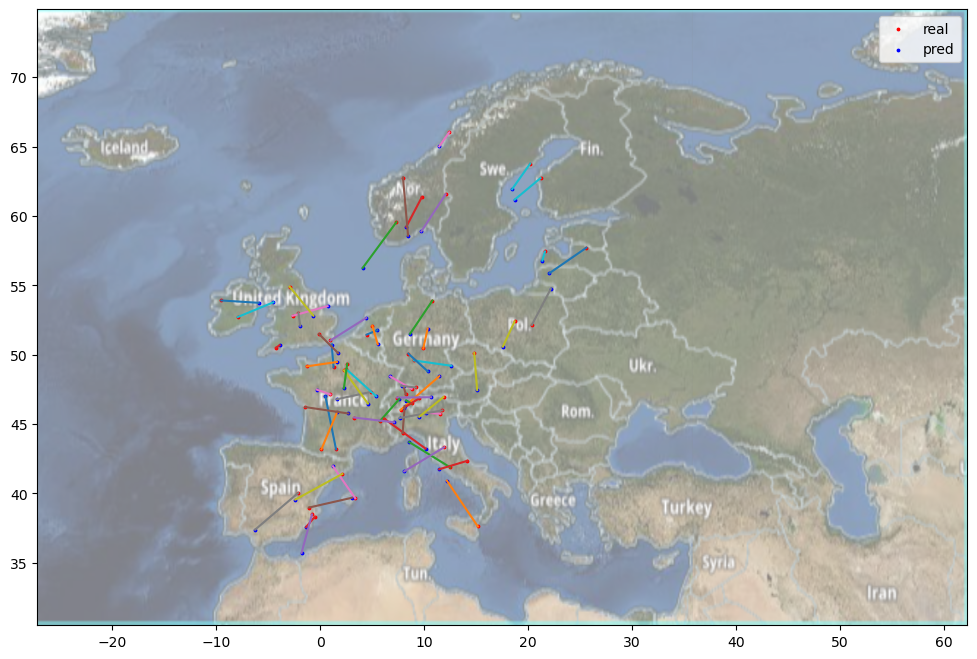

In [9]:
plt.rcParams["figure.figsize"] = (12,8)
choice_inds = errors<5
print(np.count_nonzero(choice_inds))
plt.scatter(reals[choice_inds, 1], reals[choice_inds,0], c='r', label='real', s=3)
plt.scatter(preds[choice_inds, 1], preds[choice_inds,0], c='b', label='pred', s=3)

for c1, c2 in zip(preds[choice_inds], reals[choice_inds]):
    plt.plot([c1[1], c2[1]], [c1[0], c2[0]])
    
plt.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 74.90111])
plt.legend()
plt.show()

40


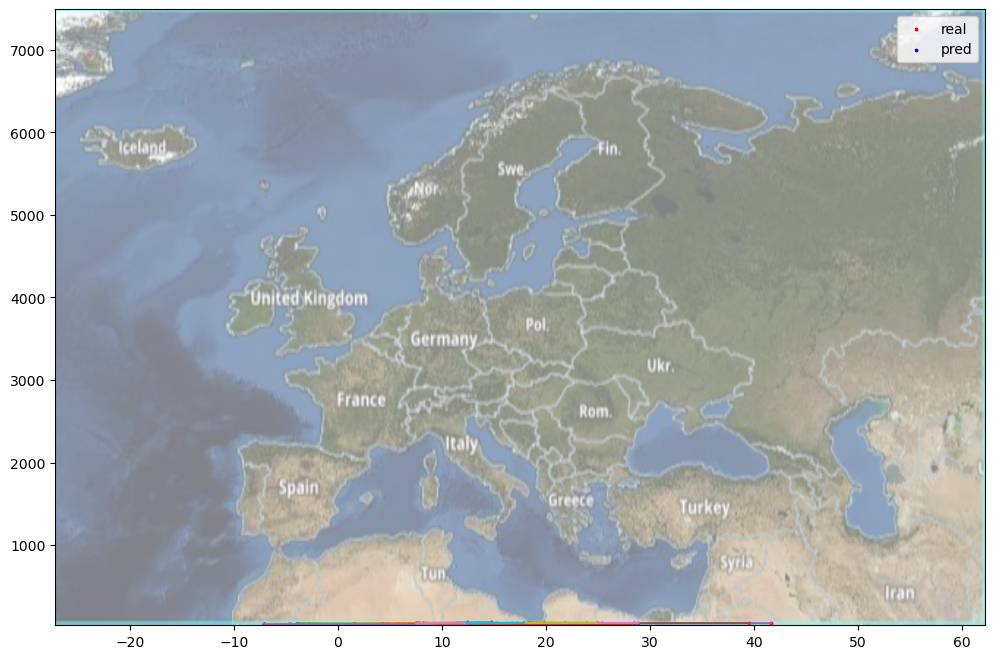

In [10]:
choice_inds = errors>5
print(np.count_nonzero(choice_inds))
plt.scatter(reals[choice_inds, 1], reals[choice_inds,0], c='r', label='real', s=3)
plt.scatter(preds[choice_inds, 1], preds[choice_inds,0], c='b', label='pred', s=3)

for c1, c2 in zip(preds[choice_inds], reals[choice_inds]):
    plt.plot([c1[1], c2[1]], [c1[0], c2[0]])
plt.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 7490.111])
plt.legend()
plt.show()

In [11]:
errors

array([ 8.42972951, 10.59016094,  8.8086817 ,  1.07348465, 24.71590306,
        4.4192535 ,  0.56904125,  1.59445564,  3.25931274,  0.63697557,
        2.24058876,  1.38174873,  2.68992986,  3.62141826,  2.27202111,
        1.48917012,  3.22636874,  9.796945  ,  7.17124763, 10.28038632,
        1.12666375,  2.9402207 ,  4.20748869,  3.15204811,  4.91060153,
       10.74531054,  4.8856665 ,  5.75836712,  2.92917732, 12.64794857,
        3.94484102,  3.11546813,  2.48502194,  4.55048336,  3.8661369 ,
        7.27564888, 18.37581239,  4.18381201,  7.55373357,  1.34213069,
        3.35523783,  3.32695929,  3.46230586,  1.64125347,  2.91594423,
        1.79268303,  0.3882964 ,  3.80708319,  2.29120139,  3.4372312 ,
        0.95728922,  3.09295918, 19.51719819, 20.29687856, 18.80584536,
       31.97332736,  7.57056758, 13.62300696,  3.58499099,  3.58825816,
       16.84903715,  4.45077627,  8.56354431, 13.01755224,  8.84639077,
        9.68560929, 16.36888356,  4.32418815,  2.78689142,  4.22

In [12]:
@torch.no_grad()
def pred_N_show(img_path):
    img = Image.open(img_path).convert("RGB")
#     print(img.size)
    img_tensor = trans(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    pred = model(img_tensor)*10
    pred = pred.squeeze()
    coord = pred.detach().cpu().numpy()+COORD_REF
    print(coord)
    plt.rcParams["figure.figsize"] = (11,4)
    
    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 2]})
    ax1.scatter([coord[1]], coord[0], c='r', label='real', s=5)
    
    ax1.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 74.90111])
    ax2.imshow(plt.imread(img_path), aspect='auto')
    plt.show()
    

[49.11320746 21.13178825]


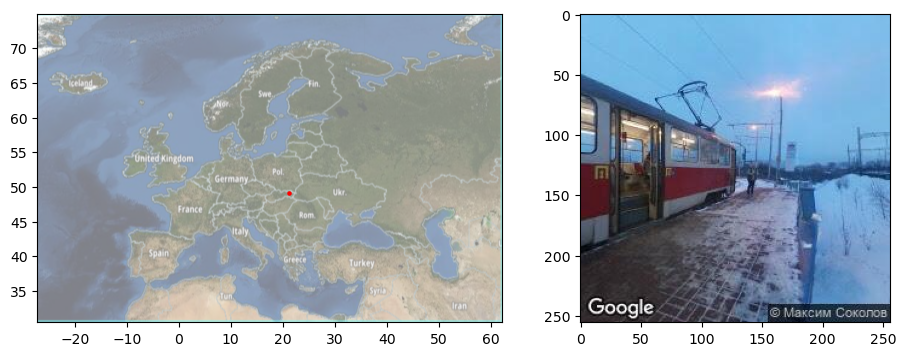

In [13]:
pred_N_show("./demo/1.png")

[47.88610291  0.47000027]


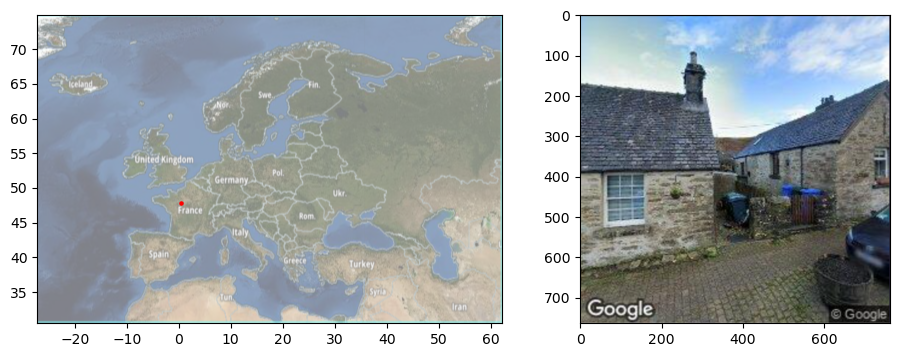

In [57]:
pred_N_show("./demo/2.png")

[39.54220581 20.68409061]


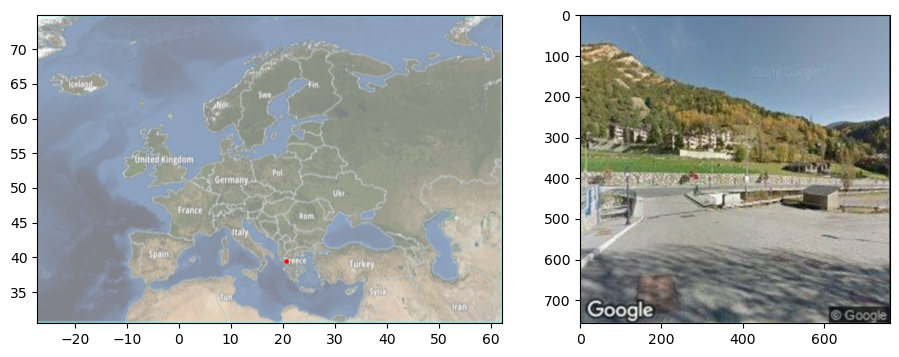

In [58]:
pred_N_show("./demo/3.png")

[43.8645277  1.6268959]


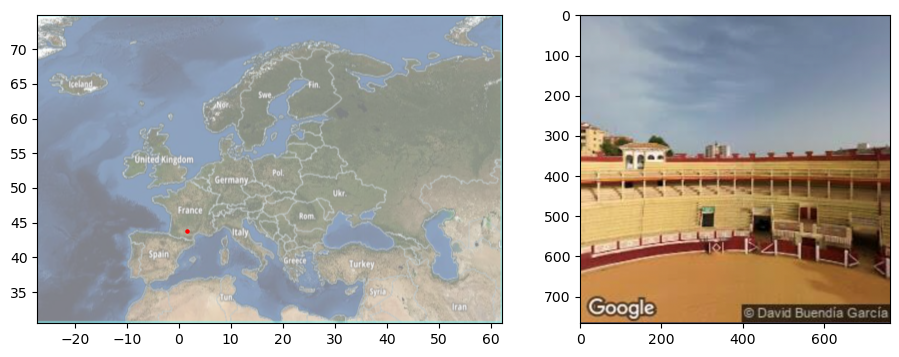

In [59]:
pred_N_show("./demo/4.png")

[45.64667177 13.95151043]


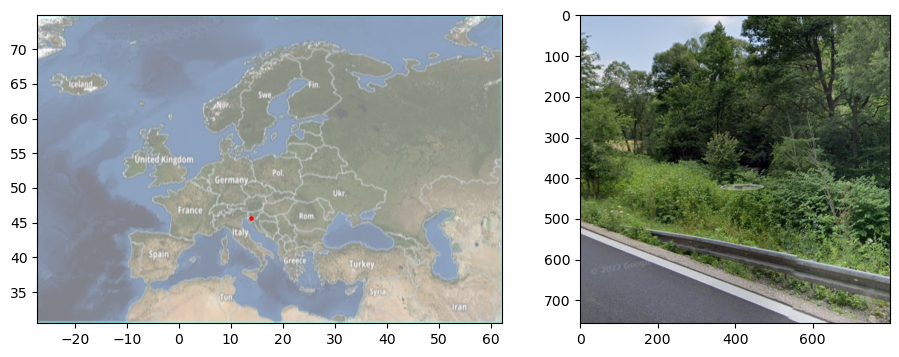

In [20]:
pred_N_show("./demo/f5baa5c0b4c5ad281bab67b9a4d0ec6.png")

[45.02214336  8.12756371]


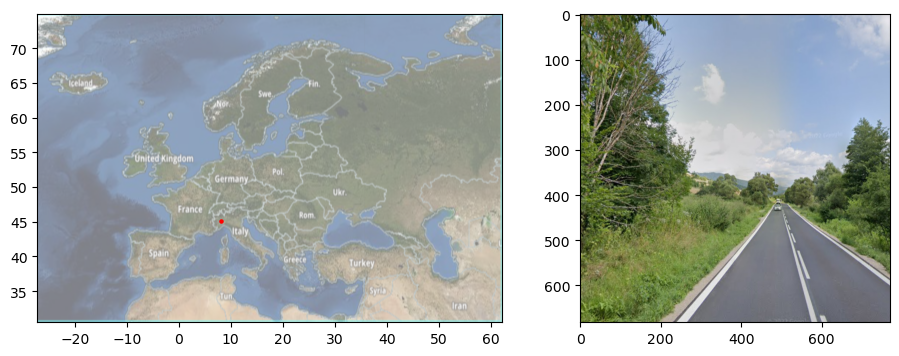

In [19]:
pred_N_show("./demo/274511ec7b851f1aa9a7075bdd219ad.png")